# Phase 2: Data Exploration & Quality Assessment

**Objective**: Understand data structure, quality, and distributions. Define study population and target variable.

## Contents
1. [Data Loading & File Summary](#1-data-loading)
2. [Missing Value Analysis](#2-missing-values)
3. [Study Population (Inclusion/Exclusion)](#3-study-population)
4. [Target Variable Definition](#4-target-variable)
5. [Key Variable Distributions](#5-distributions)
6. [Summary & Next Steps](#6-summary)

In [1]:
# Standard imports
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.data.loaders import (
    load_config, load_file_mappings, load_xpt_file,
    load_file_for_year, load_all_files_for_year, load_multiple_years,
    get_variable_info, get_file_summary
)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Load configuration
config = load_config()
print(f"Project: {config['project']['name']}")
print(f"Survey years: {config['data']['initial_years']}")

Project: nhanes-diabetes-prediction
Survey years: ['2015-2016', '2017-2018']


---
## 1. Data Loading & File Summary <a name="1-data-loading"></a>

In [2]:
# Get summary of all downloaded files
file_summary = get_file_summary()
print(f"Total files: {len(file_summary)}")
print(f"\nFiles by year:")
print(file_summary.groupby('year')['file'].count())
print(f"\nTotal size: {file_summary['size_mb'].sum():.1f} MB")

Total files: 48

Files by year:
year
2015-2016    24
2017-2018    24
Name: file, dtype: int64

Total size: 94.1 MB


In [3]:
# Display file summary sorted by size
file_summary.sort_values(['year', 'file']).head(30)

,year,file,rows,columns,size_mb
3,2015-2016,ALB_CR_I,8608,8,0.53
17,2015-2016,ALQ_I,5735,10,0.44
21,2015-2016,BIOPRO_I,6744,38,1.96
9,2015-2016,BMX_I,9544,26,1.90
22,2015-2016,BPQ_I,6327,11,0.53
7,2015-2016,BPX_I,9544,21,1.53
1,2015-2016,CBC_I,9165,21,1.47
14,2015-2016,CDQ_I,3766,17,0.49
0,2015-2016,DBQ_I,9971,51,3.89
13,2015-2016,DEMO_I,9971,47,3.58


In [4]:
# Load data for both years
years = config['data']['initial_years']
df = load_multiple_years(years)

Loading data for 2015-2016...


  Loaded 9,971 participants
Loading data for 2017-2018...


  Loaded 9,254 participants

Total combined: 19,225 participants


In [5]:
# Basic info
print(f"Shape: {df.shape}")
print(f"\nParticipants by year:")
print(df['SURVEY_YEAR'].value_counts().sort_index())

Shape: (19225, 831)

Participants by year:
SURVEY_YEAR
2015-2016    9971
2017-2018    9254
Name: count, dtype: int64


In [6]:
# Variable summary
var_info = get_variable_info(df)
print(f"Total variables: {len(var_info)}")
print(f"\nVariables by data type:")
print(var_info['dtype'].value_counts())

Total variables: 831

Variables by data type:
dtype
float64    824
object       7
Name: count, dtype: int64


---
## 2. Missing Value Analysis <a name="2-missing-values"></a>

In [7]:
# Overall missing value summary
missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)

print("Missing value distribution:")
print(f"  Variables with 0% missing: {(missing_pct == 0).sum()}")
print(f"  Variables with <5% missing: {((missing_pct > 0) & (missing_pct < 5)).sum()}")
print(f"  Variables with 5-30% missing: {((missing_pct >= 5) & (missing_pct < 30)).sum()}")
print(f"  Variables with 30-50% missing: {((missing_pct >= 30) & (missing_pct < 50)).sum()}")
print(f"  Variables with 50%+ missing: {(missing_pct >= 50).sum()}")

Missing value distribution:
  Variables with 0% missing: 21
  Variables with <5% missing: 15
  Variables with 5-30% missing: 150
  Variables with 30-50% missing: 117
  Variables with 50%+ missing: 528


In [8]:
# Top 30 variables with most missing values
missing_top = var_info.nlargest(30, 'null_pct')[['variable', 'null_pct', 'non_null', 'dtype']]
missing_top

,variable,null_pct,non_null,dtype
53,BMIHEAD,100.00,0,float64
536,MCQ240D,100.00,0,float64
543,MCQ240I,100.00,0,float64
545,MCQ240K,100.00,0,float64
552,MCQ240R,100.00,0,float64
559,MCQ240Y,100.00,0,float64
529,MCQ230D,99.99,1,float64
532,MCQ240B,99.99,2,float64
534,MCQ240C,99.99,2,float64
538,MCQ240DK,99.99,1,float64


In [9]:
# Key variables missing rates
key_vars = [
    'SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'RIDEXPRG',  # Demographics
    'BMXBMI', 'BMXWT', 'BMXHT', 'BMXWAIST',  # Body measures
    'LBXGH', 'LBXGLU',  # Target-related labs (HbA1c, glucose)
    'DIQ010', 'DIQ050', 'DIQ070',  # Diabetes questionnaire
    'BPXSY1', 'BPXDI1',  # Blood pressure
]

key_missing = var_info[var_info['variable'].isin(key_vars)][['variable', 'null_pct', 'non_null']]
key_missing = key_missing.set_index('variable').loc[[v for v in key_vars if v in key_missing.index.tolist()]]
key_missing

,null_pct,non_null
variable,,


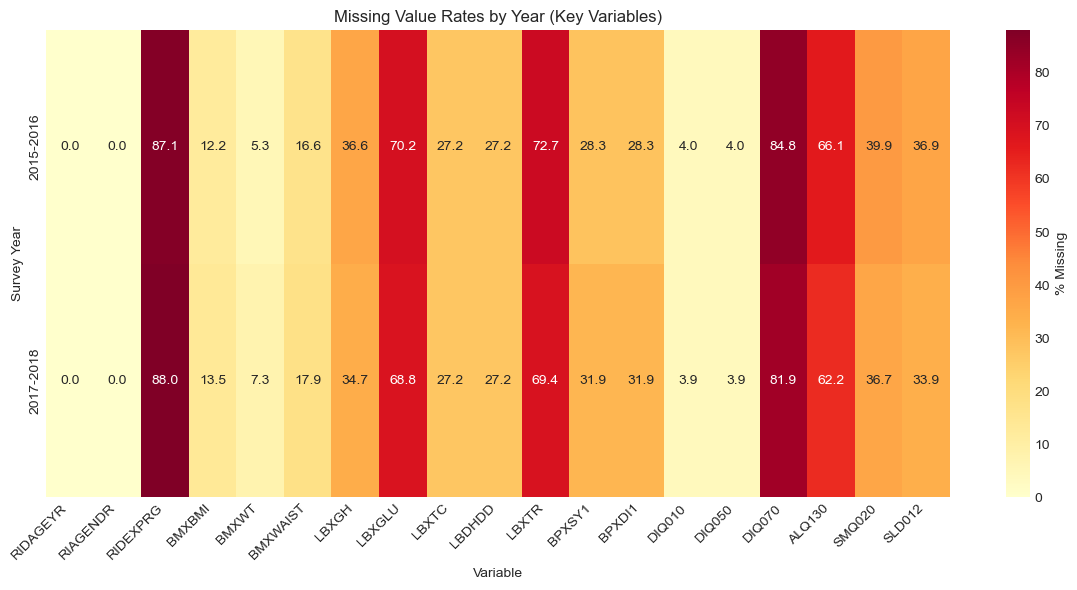

In [10]:
# Missing values heatmap for key variables
# Select a subset of important variables for visualization
important_vars = [
    # Demographics
    'RIDAGEYR', 'RIAGENDR', 'RIDEXPRG',
    # Body measures
    'BMXBMI', 'BMXWT', 'BMXWAIST',
    # Labs
    'LBXGH', 'LBXGLU', 'LBXTC', 'LBDHDD', 'LBXTR',
    # Blood pressure
    'BPXSY1', 'BPXDI1',
    # Diabetes questionnaire
    'DIQ010', 'DIQ050', 'DIQ070',
    # Lifestyle
    'ALQ130', 'SMQ020', 'SLD012',
]

# Filter to variables that exist
existing_vars = [v for v in important_vars if v in df.columns]

# Create missing indicator matrix
missing_matrix = df[existing_vars].isna().astype(int)

# Calculate missing rate by year
missing_by_year = df.groupby('SURVEY_YEAR')[existing_vars].apply(lambda x: x.isna().mean() * 100)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(missing_by_year, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': '% Missing'})
ax.set_title('Missing Value Rates by Year (Key Variables)')
ax.set_xlabel('Variable')
ax.set_ylabel('Survey Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'missing_values_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Study Population (Inclusion/Exclusion Criteria) <a name="3-study-population"></a>

**Inclusion criteria:**
- Age >= 18 years

**Exclusion criteria:**
- Pregnant participants (RIDEXPRG = 1)

In [11]:
# Initial sample
n_total = len(df)
print(f"Initial sample: {n_total:,} participants")

Initial sample: 19,225 participants


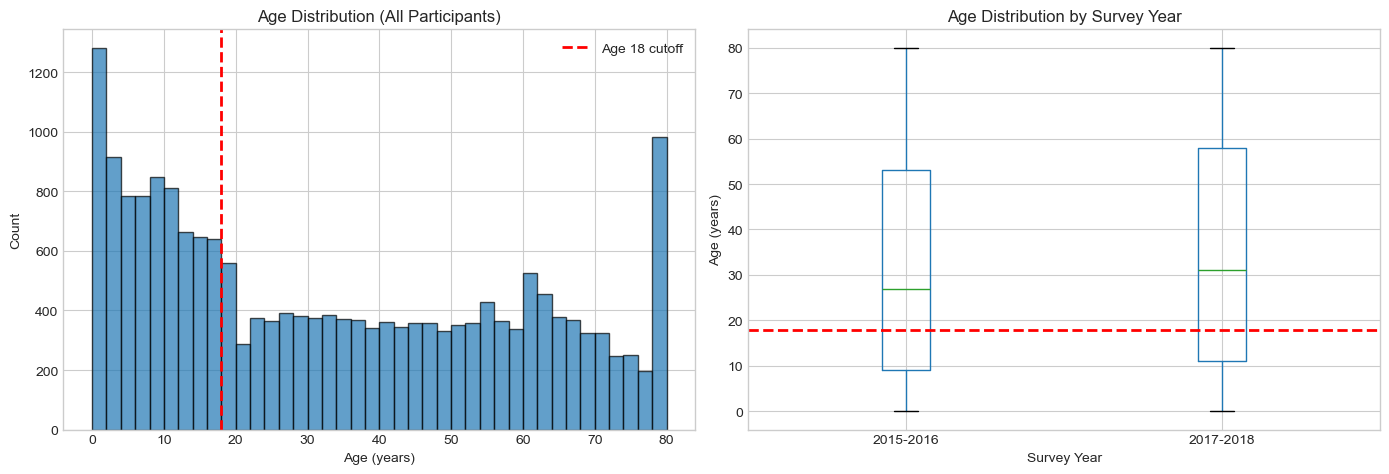

In [12]:
# Age distribution (before filtering)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df['RIDAGEYR'].hist(bins=40, ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].axvline(x=18, color='red', linestyle='--', linewidth=2, label='Age 18 cutoff')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')
axes[0].set_title('Age Distribution (All Participants)')
axes[0].legend()

# Box plot by year
df.boxplot(column='RIDAGEYR', by='SURVEY_YEAR', ax=axes[1])
axes[1].axhline(y=18, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Survey Year')
axes[1].set_ylabel('Age (years)')
axes[1].set_title('Age Distribution by Survey Year')
plt.suptitle('')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'age_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Step 1: Exclude age < 18
df_adults = df[df['RIDAGEYR'] >= 18].copy()
n_excluded_age = n_total - len(df_adults)
print(f"Excluded (age < 18): {n_excluded_age:,} ({n_excluded_age/n_total*100:.1f}%)")
print(f"Remaining: {len(df_adults):,}")

Excluded (age < 18): 7,377 (38.4%)
Remaining: 11,848


In [14]:
# Check pregnancy status variable
print("RIDEXPRG (Pregnancy status) value counts:")
print(df_adults['RIDEXPRG'].value_counts(dropna=False))
print("\nNote: 1=Yes (pregnant), 2=No, 3=Cannot determine")

RIDEXPRG (Pregnancy status) value counts:
RIDEXPRG
NaN    9450
2.0    2091
3.0     182
1.0     125
Name: count, dtype: int64

Note: 1=Yes (pregnant), 2=No, 3=Cannot determine


In [15]:
# Step 2: Exclude pregnant participants (RIDEXPRG = 1)
n_before_preg = len(df_adults)
df_study = df_adults[df_adults['RIDEXPRG'] != 1].copy()
n_excluded_pregnant = n_before_preg - len(df_study)
print(f"Excluded (pregnant): {n_excluded_pregnant:,} ({n_excluded_pregnant/n_before_preg*100:.1f}%)")
print(f"Final study population: {len(df_study):,}")

Excluded (pregnant): 125 (1.1%)
Final study population: 11,723


In [16]:
# Cohort flow summary
cohort_flow = pd.DataFrame([
    {'Step': 'Total NHANES participants (2015-2018)', 'N': n_total, 'Excluded': '-', 'Reason': '-'},
    {'Step': 'After excluding age < 18', 'N': len(df_adults), 'Excluded': n_excluded_age, 'Reason': 'Pediatric (age < 18)'},
    {'Step': 'After excluding pregnant', 'N': len(df_study), 'Excluded': n_excluded_pregnant, 'Reason': 'Pregnant participants'},
])
print("\n=== COHORT FLOW ===")
print(cohort_flow.to_string(index=False))


=== COHORT FLOW ===
                                 Step     N Excluded                Reason
Total NHANES participants (2015-2018) 19225        -                     -
             After excluding age < 18 11848     7377  Pediatric (age < 18)
             After excluding pregnant 11723      125 Pregnant participants


In [17]:
# Study population by year
print("\nStudy population by survey year:")
print(df_study['SURVEY_YEAR'].value_counts().sort_index())


Study population by survey year:
SURVEY_YEAR
2015-2016    5922
2017-2018    5801
Name: count, dtype: int64


In [18]:
# Demographics of study population
print("\n=== STUDY POPULATION DEMOGRAPHICS ===")
print(f"\nTotal N: {len(df_study):,}")
print(f"\nAge: mean={df_study['RIDAGEYR'].mean():.1f}, median={df_study['RIDAGEYR'].median():.0f}, range=[{df_study['RIDAGEYR'].min():.0f}-{df_study['RIDAGEYR'].max():.0f}]")

print("\nGender (RIAGENDR):")
gender_counts = df_study['RIAGENDR'].value_counts().sort_index()
for val, count in gender_counts.items():
    label = 'Male' if val == 1 else 'Female'
    print(f"  {label}: {count:,} ({count/len(df_study)*100:.1f}%)")


=== STUDY POPULATION DEMOGRAPHICS ===

Total N: 11,723

Age: mean=49.2, median=50, range=[18-80]

Gender (RIAGENDR):
  Male: 5,727 (48.9%)
  Female: 5,996 (51.1%)


---
## 4. Target Variable Definition <a name="4-target-variable"></a>

### 4.1 Classification Target (3-class)

| Class | Criteria | Priority |
|-------|----------|----------|
| **Diabetes** | DIQ010=1 OR HbA1c>=6.5% OR Fasting glucose>=126 | Highest |
| **Prediabetes** | NOT diabetes AND (HbA1c 5.7-6.4% OR Fasting glucose 100-125) | Second |
| **No diabetes** | Does not meet above criteria | Default |

### 4.2 Regression Target
- HbA1c (LBXGH) continuous value

In [19]:
# Check target-related variables
target_vars = ['DIQ010', 'LBXGH', 'LBXGLU', 'DIQ050', 'DIQ070']
print("Target-related variables:")
for var in target_vars:
    if var in df_study.columns:
        n_valid = df_study[var].notna().sum()
        pct_valid = n_valid / len(df_study) * 100
        print(f"  {var}: {n_valid:,} valid ({pct_valid:.1f}%)")

Target-related variables:
  DIQ010: 11,723 valid (100.0%)
  LBXGH: 10,595 valid (90.4%)
  LBXGLU: 5,060 valid (43.2%)
  DIQ050: 11,723 valid (100.0%)
  DIQ070: 3,084 valid (26.3%)


In [20]:
# DIQ010: Doctor told you have diabetes
print("DIQ010 - 'Doctor told you have diabetes':")
print(df_study['DIQ010'].value_counts(dropna=False).sort_index())
print("\nCodes: 1=Yes, 2=No, 3=Borderline, 7=Refused, 9=Don't know")

DIQ010 - 'Doctor told you have diabetes':
DIQ010
1.0    1721
2.0    9688
3.0     306
9.0       8
Name: count, dtype: int64

Codes: 1=Yes, 2=No, 3=Borderline, 7=Refused, 9=Don't know


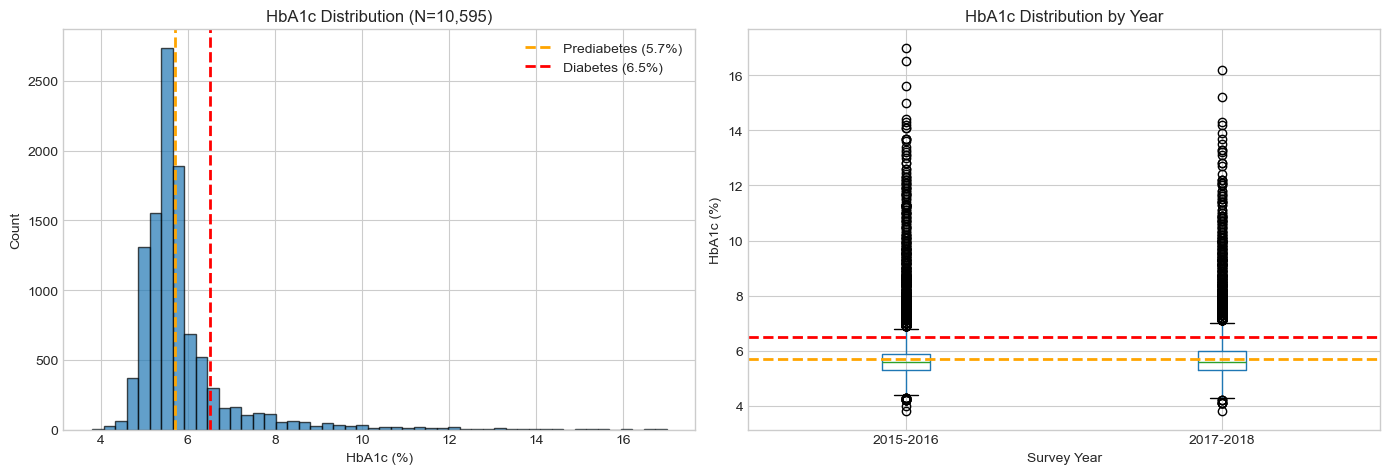


HbA1c statistics:
count    10595.000000
mean         5.835894
std          1.129701
min          3.800000
25%          5.300000
50%          5.600000
75%          5.900000
max         17.000000
Name: LBXGH, dtype: float64


In [21]:
# HbA1c distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with thresholds
hba1c = df_study['LBXGH'].dropna()
axes[0].hist(hba1c, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=5.7, color='orange', linestyle='--', linewidth=2, label='Prediabetes (5.7%)')
axes[0].axvline(x=6.5, color='red', linestyle='--', linewidth=2, label='Diabetes (6.5%)')
axes[0].set_xlabel('HbA1c (%)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'HbA1c Distribution (N={len(hba1c):,})')
axes[0].legend()

# Box plot by year
df_study.boxplot(column='LBXGH', by='SURVEY_YEAR', ax=axes[1])
axes[1].axhline(y=5.7, color='orange', linestyle='--', linewidth=2)
axes[1].axhline(y=6.5, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Survey Year')
axes[1].set_ylabel('HbA1c (%)')
axes[1].set_title('HbA1c Distribution by Year')
plt.suptitle('')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'hba1c_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nHbA1c statistics:")
print(hba1c.describe())

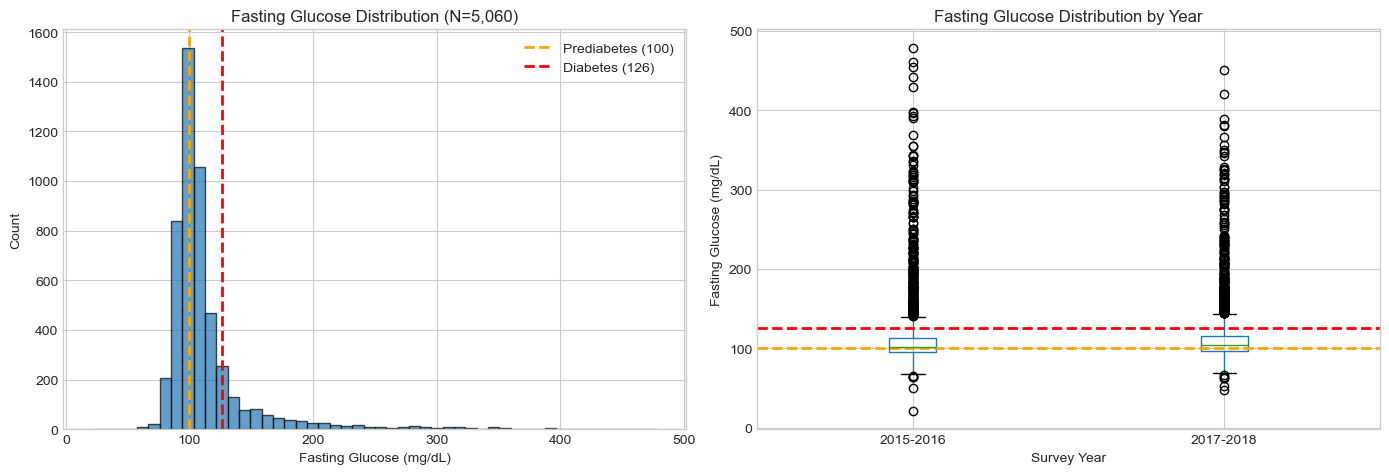


Fasting glucose statistics:
count    5060.000000
mean      113.443676
std        39.102809
min        21.000000
25%        96.000000
50%       103.000000
75%       114.000000
max       479.000000
Name: LBXGLU, dtype: float64


In [22]:
# Fasting glucose distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

glucose = df_study['LBXGLU'].dropna()
axes[0].hist(glucose, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=100, color='orange', linestyle='--', linewidth=2, label='Prediabetes (100)')
axes[0].axvline(x=126, color='red', linestyle='--', linewidth=2, label='Diabetes (126)')
axes[0].set_xlabel('Fasting Glucose (mg/dL)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Fasting Glucose Distribution (N={len(glucose):,})')
axes[0].legend()

# Note: Fasting glucose has much more missing data (fasting subsample only)
df_study.boxplot(column='LBXGLU', by='SURVEY_YEAR', ax=axes[1])
axes[1].axhline(y=100, color='orange', linestyle='--', linewidth=2)
axes[1].axhline(y=126, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Survey Year')
axes[1].set_ylabel('Fasting Glucose (mg/dL)')
axes[1].set_title('Fasting Glucose Distribution by Year')
plt.suptitle('')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'glucose_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFasting glucose statistics:")
print(glucose.describe())

In [23]:
def create_diabetes_target(df):
    """
    Create 3-class diabetes target variable.
    
    Classification rules (in priority order):
    1. DIABETES (2): DIQ010=1 OR HbA1c>=6.5 OR fasting glucose>=126
    2. PREDIABETES (1): NOT diabetes AND (HbA1c 5.7-6.4 OR fasting glucose 100-125)
    3. NO DIABETES (0): All others with sufficient data
    
    Returns NaN if insufficient data to classify.
    """
    target = pd.Series(index=df.index, dtype='float64')
    
    # Extract relevant columns
    diq010 = df['DIQ010']  # Doctor told have diabetes
    hba1c = df['LBXGH']    # Glycohemoglobin
    glucose = df['LBXGLU'] # Fasting glucose
    
    # Diabetes criteria (any one is sufficient)
    has_diabetes = (
        (diq010 == 1) |           # Self-reported diagnosis
        (hba1c >= 6.5) |          # HbA1c >= 6.5%
        (glucose >= 126)          # Fasting glucose >= 126 mg/dL
    )
    
    # Prediabetes criteria (only if not already diabetic)
    has_prediabetes = (
        ~has_diabetes &
        (
            ((hba1c >= 5.7) & (hba1c < 6.5)) |    # HbA1c 5.7-6.4%
            ((glucose >= 100) & (glucose < 126))  # Fasting glucose 100-125
        )
    )
    
    # No diabetes: not diabetic, not prediabetic, and has some diagnostic data
    has_data = (
        (diq010.notna() & (diq010 == 2)) |  # Said no to diabetes
        hba1c.notna() |                      # Has HbA1c
        glucose.notna()                      # Has glucose
    )
    has_no_diabetes = ~has_diabetes & ~has_prediabetes & has_data
    
    # Assign values
    target[has_diabetes] = 2
    target[has_prediabetes] = 1
    target[has_no_diabetes] = 0
    
    return target

# Create target
df_study['DIABETES_STATUS'] = create_diabetes_target(df_study)

In [24]:
# Target distribution
target_counts = df_study['DIABETES_STATUS'].value_counts(dropna=False).sort_index()
print("Target variable distribution:")
labels = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}
for val, count in target_counts.items():
    if pd.isna(val):
        label = 'Missing'
    else:
        label = labels.get(int(val), 'Unknown')
    pct = count / len(df_study) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")

Target variable distribution:
  No Diabetes: 5,684 (48.5%)
  Prediabetes: 3,795 (32.4%)
  Diabetes: 2,219 (18.9%)
  Missing: 25 (0.2%)


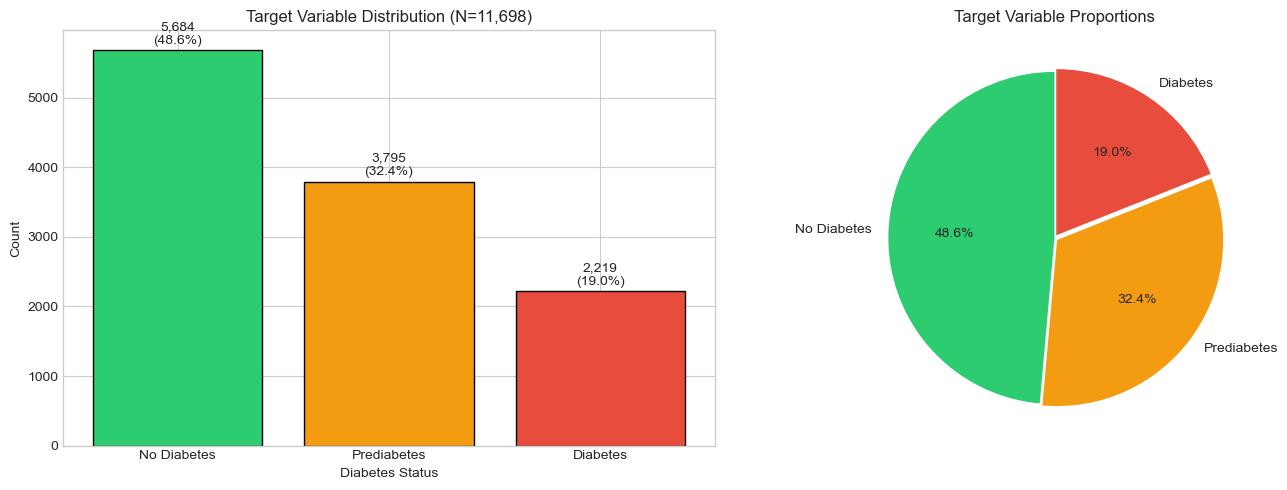

In [25]:
# Visualization of target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter to non-missing
df_with_target = df_study[df_study['DIABETES_STATUS'].notna()].copy()
df_with_target['DIABETES_LABEL'] = df_with_target['DIABETES_STATUS'].map(labels)

# Bar chart
target_order = ['No Diabetes', 'Prediabetes', 'Diabetes']
colors = ['#2ecc71', '#f39c12', '#e74c3c']
counts = df_with_target['DIABETES_LABEL'].value_counts().reindex(target_order)
bars = axes[0].bar(target_order, counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Diabetes Status')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Target Variable Distribution (N={len(df_with_target):,})')

# Add percentage labels
for bar, count in zip(bars, counts.values):
    pct = count / len(df_with_target) * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Pie chart
axes[1].pie(counts.values, labels=target_order, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=[0, 0.02, 0.02])
axes[1].set_title('Target Variable Proportions')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Concordance analysis: How often do diagnostic criteria agree?
print("=== CONCORDANCE ANALYSIS ===")
print("\nDiabetes indicators overlap:")

# Define each criterion
self_reported = df_study['DIQ010'] == 1
hba1c_diabetes = df_study['LBXGH'] >= 6.5
glucose_diabetes = df_study['LBXGLU'] >= 126

# Count overlaps
print(f"\nSelf-reported diabetes only: {(self_reported & ~hba1c_diabetes.fillna(False) & ~glucose_diabetes.fillna(False)).sum():,}")
print(f"HbA1c >= 6.5% only: {(hba1c_diabetes & ~self_reported.fillna(False) & ~glucose_diabetes.fillna(False)).sum():,}")
print(f"Fasting glucose >= 126 only: {(glucose_diabetes & ~self_reported.fillna(False) & ~hba1c_diabetes.fillna(False)).sum():,}")
print(f"\nAll three criteria agree (diabetic): {(self_reported & hba1c_diabetes & glucose_diabetes).sum():,}")
print(f"Self-reported + HbA1c: {(self_reported & hba1c_diabetes & ~glucose_diabetes.fillna(False)).sum():,}")
print(f"Self-reported + Glucose: {(self_reported & glucose_diabetes & ~hba1c_diabetes.fillna(False)).sum():,}")
print(f"HbA1c + Glucose (not self-reported): {(hba1c_diabetes & glucose_diabetes & ~self_reported.fillna(False)).sum():,}")

=== CONCORDANCE ANALYSIS ===

Diabetes indicators overlap:

Self-reported diabetes only: 545
HbA1c >= 6.5% only: 235
Fasting glucose >= 126 only: 154

All three criteria agree (diabetic): 449
Self-reported + HbA1c: 647
Self-reported + Glucose: 80
HbA1c + Glucose (not self-reported): 109


Participants with both HbA1c and Fasting Glucose: 5,056


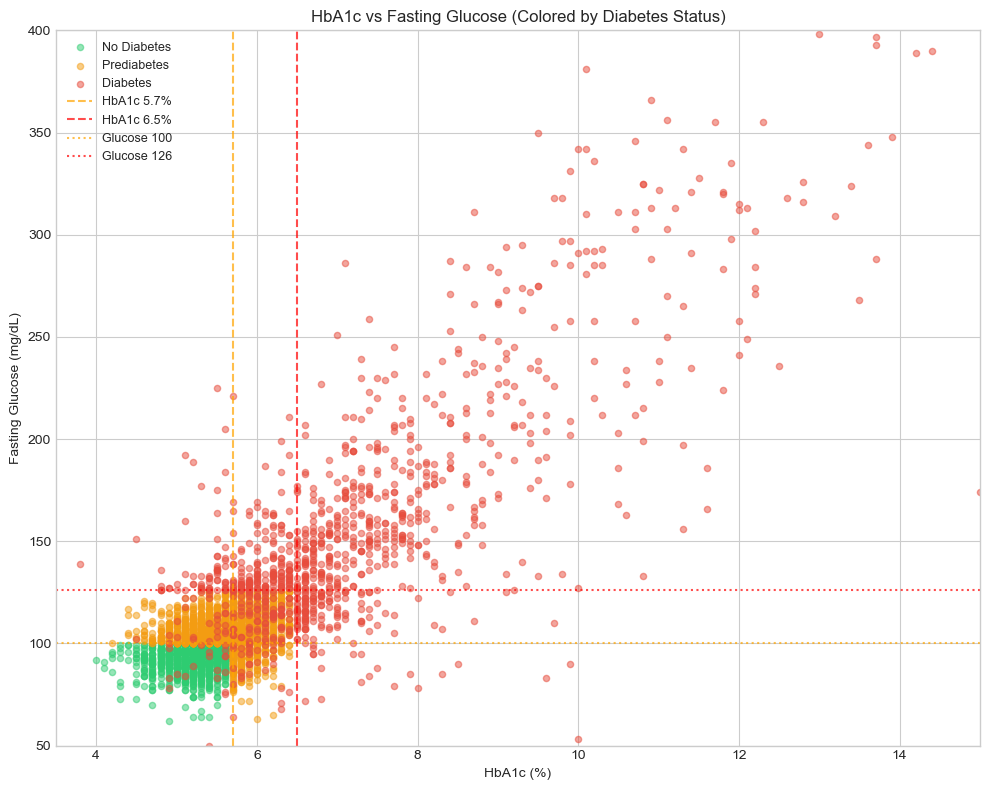

In [27]:
# HbA1c vs Glucose scatter for participants with both measures
df_both = df_study.dropna(subset=['LBXGH', 'LBXGLU']).copy()
print(f"Participants with both HbA1c and Fasting Glucose: {len(df_both):,}")

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot colored by target
for status, label, color in [(0, 'No Diabetes', '#2ecc71'), (1, 'Prediabetes', '#f39c12'), (2, 'Diabetes', '#e74c3c')]:
    mask = df_both['DIABETES_STATUS'] == status
    ax.scatter(df_both.loc[mask, 'LBXGH'], df_both.loc[mask, 'LBXGLU'], 
               c=color, label=label, alpha=0.5, s=20)

# Add threshold lines
ax.axvline(x=5.7, color='orange', linestyle='--', alpha=0.7, label='HbA1c 5.7%')
ax.axvline(x=6.5, color='red', linestyle='--', alpha=0.7, label='HbA1c 6.5%')
ax.axhline(y=100, color='orange', linestyle=':', alpha=0.7, label='Glucose 100')
ax.axhline(y=126, color='red', linestyle=':', alpha=0.7, label='Glucose 126')

ax.set_xlabel('HbA1c (%)')
ax.set_ylabel('Fasting Glucose (mg/dL)')
ax.set_title('HbA1c vs Fasting Glucose (Colored by Diabetes Status)')
ax.legend(loc='upper left', fontsize=9)
ax.set_xlim(3.5, 15)
ax.set_ylim(50, 400)

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'hba1c_vs_glucose.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Key Variable Distributions <a name="5-distributions"></a>

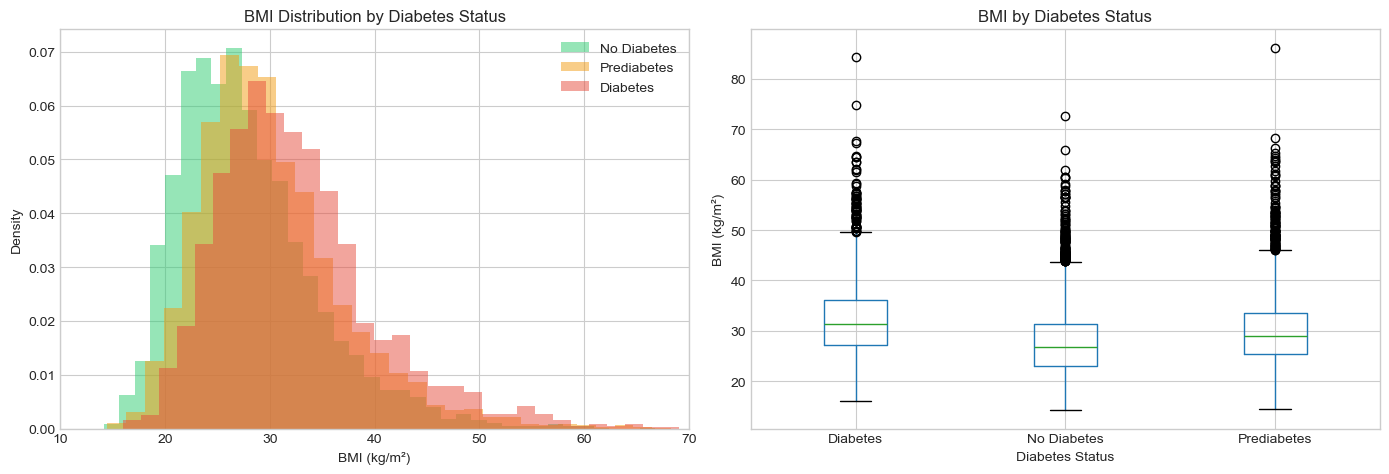

BMI by Diabetes Status:
                 count  mean  std   min   25%   50%   75%   max
DIABETES_LABEL                                                 
Diabetes        2094.0  32.5  7.7  16.0  27.2  31.3  36.2  84.4
No Diabetes     5112.0  27.8  6.7  14.2  23.0  26.7  31.3  72.6
Prediabetes     3756.0  30.1  7.1  14.5  25.3  29.0  33.6  86.2


In [28]:
# BMI distribution by diabetes status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter to those with target and BMI
df_plot = df_study.dropna(subset=['BMXBMI', 'DIABETES_STATUS']).copy()
df_plot['DIABETES_LABEL'] = df_plot['DIABETES_STATUS'].map(labels)

# Histogram by status
for status, label, color in [(0, 'No Diabetes', '#2ecc71'), (1, 'Prediabetes', '#f39c12'), (2, 'Diabetes', '#e74c3c')]:
    data = df_plot[df_plot['DIABETES_STATUS'] == status]['BMXBMI']
    axes[0].hist(data, bins=40, alpha=0.5, label=label, color=color, density=True)

axes[0].set_xlabel('BMI (kg/m²)')
axes[0].set_ylabel('Density')
axes[0].set_title('BMI Distribution by Diabetes Status')
axes[0].legend()
axes[0].set_xlim(10, 70)

# Box plot
df_plot.boxplot(column='BMXBMI', by='DIABETES_LABEL', ax=axes[1],
                positions=[0, 1, 2])
axes[1].set_xlabel('Diabetes Status')
axes[1].set_ylabel('BMI (kg/m²)')
axes[1].set_title('BMI by Diabetes Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'bmi_by_diabetes_status.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("BMI by Diabetes Status:")
print(df_plot.groupby('DIABETES_LABEL')['BMXBMI'].describe().round(1))

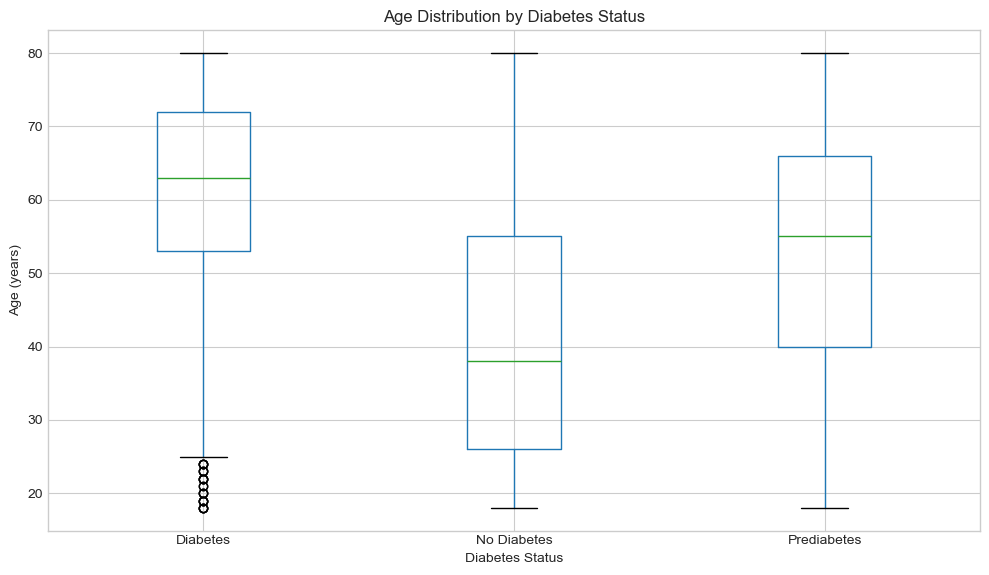


Age by Diabetes Status:
                 count  mean   std   min   25%   50%   75%   max
DIABETES_LABEL                                                  
Diabetes        2219.0  61.5  13.5  18.0  53.0  63.0  72.0  80.0
No Diabetes     5684.0  41.7  18.0  18.0  26.0  38.0  55.0  80.0
Prediabetes     3795.0  53.1  17.1  18.0  40.0  55.0  66.0  80.0


In [29]:
# Age distribution by diabetes status
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = df_study.dropna(subset=['DIABETES_STATUS']).copy()
df_plot['DIABETES_LABEL'] = df_plot['DIABETES_STATUS'].map(labels)

df_plot.boxplot(column='RIDAGEYR', by='DIABETES_LABEL', ax=ax, positions=[0, 1, 2])
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Age (years)')
ax.set_title('Age Distribution by Diabetes Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'age_by_diabetes_status.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAge by Diabetes Status:")
print(df_plot.groupby('DIABETES_LABEL')['RIDAGEYR'].describe().round(1))

In [30]:
# Gender distribution by diabetes status
df_plot = df_study.dropna(subset=['DIABETES_STATUS']).copy()
df_plot['GENDER_LABEL'] = df_plot['RIAGENDR'].map({1: 'Male', 2: 'Female'})
df_plot['DIABETES_LABEL'] = df_plot['DIABETES_STATUS'].map(labels)

# Cross-tabulation
crosstab = pd.crosstab(df_plot['DIABETES_LABEL'], df_plot['GENDER_LABEL'], margins=True)
print("Diabetes Status by Gender:")
print(crosstab)

# Row percentages
print("\nRow percentages:")
print(pd.crosstab(df_plot['DIABETES_LABEL'], df_plot['GENDER_LABEL'], normalize='index').round(3) * 100)

Diabetes Status by Gender:
GENDER_LABEL    Female  Male    All
DIABETES_LABEL                     
Diabetes          1044  1175   2219
No Diabetes       3070  2614   5684
Prediabetes       1868  1927   3795
All               5982  5716  11698

Row percentages:
GENDER_LABEL    Female  Male
DIABETES_LABEL              
Diabetes          47.0  53.0
No Diabetes       54.0  46.0
Prediabetes       49.2  50.8


---
## 6. Summary & Next Steps <a name="6-summary"></a>

In [31]:
# Final summary
print("="*60)
print("PHASE 2 SUMMARY: Data Exploration & Quality Assessment")
print("="*60)

print("\n1. DATA OVERVIEW")
print(f"   Total files: {len(file_summary)}")
print(f"   Total variables: {len(df.columns)}")
print(f"   Survey years: {', '.join(years)}")

print("\n2. STUDY POPULATION")
print(f"   Initial sample: {n_total:,}")
print(f"   After exclusions: {len(df_study):,}")
print(f"   - Excluded (age < 18): {n_excluded_age:,}")
print(f"   - Excluded (pregnant): {n_excluded_pregnant:,}")

print("\n3. TARGET VARIABLE (N with target defined)")
n_with_target = df_study['DIABETES_STATUS'].notna().sum()
for status in [0, 1, 2]:
    count = (df_study['DIABETES_STATUS'] == status).sum()
    pct = count / n_with_target * 100
    print(f"   {labels[status]}: {count:,} ({pct:.1f}%)")
print(f"   Missing: {df_study['DIABETES_STATUS'].isna().sum():,}")

print("\n4. KEY FINDINGS")
print("   - Class imbalance: majority are 'No Diabetes'")
print("   - BMI is higher in diabetic vs non-diabetic groups")
print("   - Age is higher in diabetic vs non-diabetic groups")
print("   - Fasting glucose has more missing data than HbA1c (fasting subsample)")

print("\n5. NEXT STEPS (Phase 3)")
print("   - Handle missing values (imputation strategy)")
print("   - Variable harmonization across years")
print("   - Data quality checks and validation")
print("   - Feature engineering")

PHASE 2 SUMMARY: Data Exploration & Quality Assessment

1. DATA OVERVIEW
   Total files: 48
   Total variables: 831
   Survey years: 2015-2016, 2017-2018

2. STUDY POPULATION
   Initial sample: 19,225
   After exclusions: 11,723
   - Excluded (age < 18): 7,377
   - Excluded (pregnant): 125

3. TARGET VARIABLE (N with target defined)
   No Diabetes: 5,684 (48.6%)
   Prediabetes: 3,795 (32.4%)
   Diabetes: 2,219 (19.0%)
   Missing: 25

4. KEY FINDINGS
   - Class imbalance: majority are 'No Diabetes'
   - BMI is higher in diabetic vs non-diabetic groups
   - Age is higher in diabetic vs non-diabetic groups
   - Fasting glucose has more missing data than HbA1c (fasting subsample)

5. NEXT STEPS (Phase 3)
   - Handle missing values (imputation strategy)
   - Variable harmonization across years
   - Data quality checks and validation
   - Feature engineering


In [32]:
# Save study population dataframe for next phase
output_path = project_root / 'data' / 'interim' / 'study_population.parquet'
df_study.to_parquet(output_path, index=False)
print(f"\nStudy population saved to: {output_path}")
print(f"Shape: {df_study.shape}")


Study population saved to: /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/data/interim/study_population.parquet
Shape: (11723, 832)
